In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [ ]:
spark = SparkSession.builder.appName("UAS").getOrCreate()
data = spark.read.csv('/content/drive/MyDrive/Kuliah/Semester 5/Big data lanjut/UAS/diabetes_prediction_dataset.csv', header = True, inferSchema = True)

In [ ]:
data.printSchema()

root
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- smoking_history: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- HbA1c_level: double (nullable = true)
 |-- blood_glucose_level: integer (nullable = true)
 |-- diabetes: integer (nullable = true)



#Penjelasan Setiap Kolom

1.	gender: Jenis kelamin pasien (Laki-laki atau Perempuan).
2.	age: Usia pasien dalam tahun.
3.	hypertension: Riwayat hipertensi (0: Tidak, 1: Ya).
4.	heart_disease: Riwayat penyakit jantung (0: Tidak, 1: Ya).
5.	smoking_history: Riwayat merokok (current, former, never, ever, not current, no info).
6.	bmi: Body Mass Index (BMI) pasien, ukuran lemak tubuh berdasarkan tinggi dan berat badan.
7.	HbA1c_level: Kadar HbA1c, indikator rata-rata kadar gula darah selama 2-3 bulan terakhir.
8.	blood_glucose_level: Kadar glukosa darah, ukuran kadar gula dalam darah.
9.	diabetes: Status diabetes (0: Tidak, 1: Ya).


In [ ]:
data.describe().show()

+-------+------+-----------------+------------------+------------------+---------------+-----------------+------------------+-------------------+-------------------+
|summary|gender|              age|      hypertension|     heart_disease|smoking_history|              bmi|       HbA1c_level|blood_glucose_level|           diabetes|
+-------+------+-----------------+------------------+------------------+---------------+-----------------+------------------+-------------------+-------------------+
|  count|100000|           100000|            100000|            100000|         100000|           100000|            100000|             100000|             100000|
|   mean|  NULL|41.88585600000013|           0.07485|           0.03942|           NULL|27.32076709999422|5.5275069999983275|          138.05806|              0.085|
| stddev|  NULL|22.51683987161704|0.2631504702289171|0.1945930169980986|           NULL|6.636783416648357|1.0706720918835468|  40.70813604870383|0.27888308976661896|
|   

In [ ]:
# Mengganti nama kolom
data = data.toDF(*[col.replace("_", "-") for col in data.columns])

In [ ]:
data.show()

+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|gender| age|hypertension|heart-disease|smoking-history|  bmi|HbA1c-level|blood-glucose-level|diabetes|
+------+----+------------+-------------+---------------+-----+-----------+-------------------+--------+
|Female|80.0|           0|            1|          never|25.19|        6.6|                140|       0|
|Female|54.0|           0|            0|        No Info|27.32|        6.6|                 80|       0|
|  Male|28.0|           0|            0|          never|27.32|        5.7|                158|       0|
|Female|36.0|           0|            0|        current|23.45|        5.0|                155|       0|
|  Male|76.0|           1|            1|        current|20.14|        4.8|                155|       0|
|Female|20.0|           0|            0|          never|27.32|        6.6|                 85|       0|
|Female|44.0|           0|            0|          never|19.31|  

In [ ]:
# Memeriksa nilai null
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+------+---+------------+-------------+---------------+---+-----------+-------------------+--------+
|gender|age|hypertension|heart-disease|smoking-history|bmi|HbA1c-level|blood-glucose-level|diabetes|
+------+---+------------+-------------+---------------+---+-----------+-------------------+--------+
|     0|  0|           0|            0|              0|  0|          0|                  0|       0|
+------+---+------------+-------------+---------------+---+-----------+-------------------+--------+



Matriks Korelasi:
                           age  hypertension  heart-disease       bmi  \
age                  1.000000      0.251171       0.233354  0.337396   
hypertension         0.251171      1.000000       0.121262  0.147666   
heart-disease        0.233354      0.121262       1.000000  0.061198   
bmi                  0.337396      0.147666       0.061198  1.000000   
HbA1c-level          0.101354      0.080939       0.067589  0.082997   
blood-glucose-level  0.110672      0.084429       0.070066  0.091261   

                     HbA1c-level  blood-glucose-level  
age                     0.101354             0.110672  
hypertension            0.080939             0.084429  
heart-disease           0.067589             0.070066  
bmi                     0.082997             0.091261  
HbA1c-level             1.000000             0.166733  
blood-glucose-level     0.166733             1.000000  


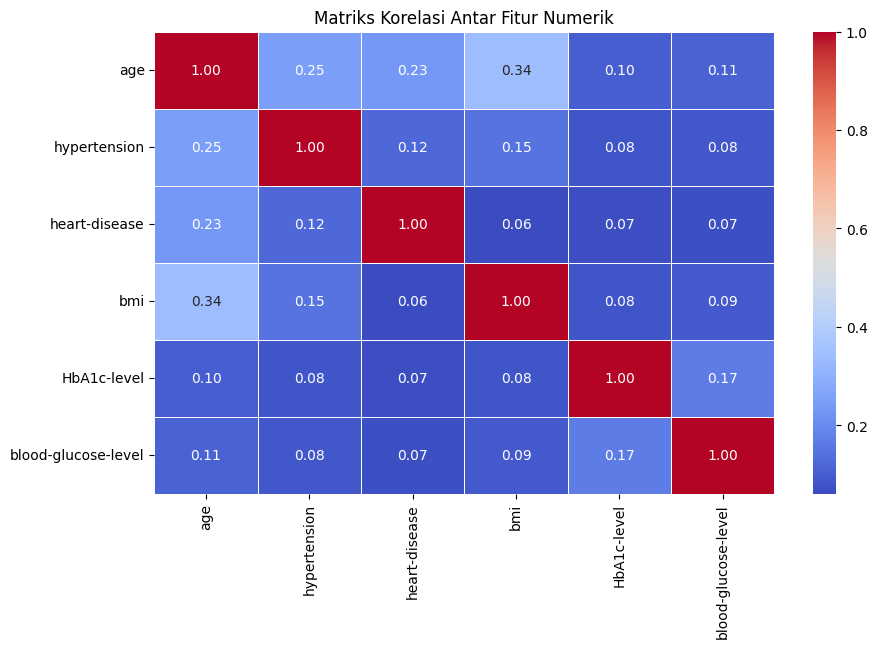

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Mengambil hanya kolom numerik untuk analisis korelasi
numerical_cols = ["age", "hypertension", "heart-disease", "bmi", "HbA1c-level", "blood-glucose-level"]

# Mengubah DataFrame PySpark menjadi Pandas DataFrame untuk perhitungan korelasi
df_numerical = data.select(numerical_cols).toPandas()

# Menghitung matriks korelasi
corr_matrix = df_numerical.corr()

# Menampilkan matriks korelasi
print("Matriks Korelasi:\n", corr_matrix)

# Visualisasi matriks korelasi dengan heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriks Korelasi Antar Fitur Numerik")
plt.show()

In [ ]:
# Mengubah kolom kategorikal menjadi numerik
indexer_gender = StringIndexer(inputCol="gender", outputCol="gender-index")
indexer_smoking = StringIndexer(inputCol="smoking-history", outputCol="smoking-index")

In [ ]:
data = indexer_gender.fit(data).transform(data)
data = indexer_smoking.fit(data).transform(data)

#EDA

<ipython-input-50-cec0ec1a942e>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="gender", y="count", data=gender_count, palette="muted")


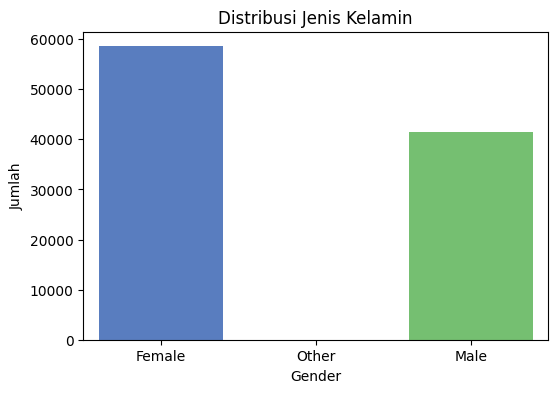

In [ ]:
# Menghitung jumlah gender
gender_count = data.groupBy("gender").count().toPandas()

# Membuat bar chart
plt.figure(figsize=(6, 4))
sns.barplot(x="gender", y="count", data=gender_count, palette="muted")
plt.title("Distribusi Jenis Kelamin")
plt.xlabel("Gender")
plt.ylabel("Jumlah")
plt.show()

Grafik batang ini menunjukkan jumlah individu berdasarkan jenis kelamin (Female, Male, Other). Sumbu X adalah kategori jenis kelamin, dan sumbu Y adalah jumlah individu.

Kategori "Female" memiliki jumlah tertinggi, diikuti oleh "Male", sementara "Other" sangat kecil. Hal ini menunjukkan bahwa dataset didominasi oleh individu perempuan.

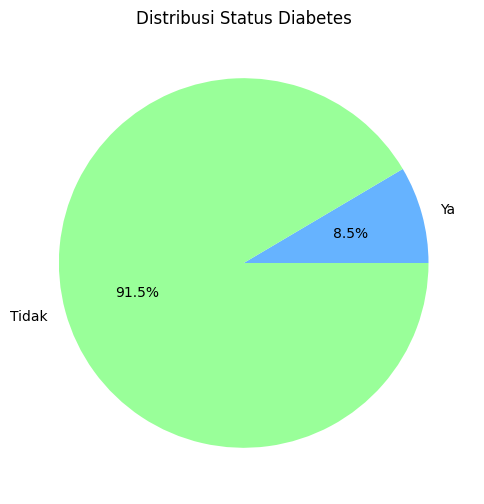

In [ ]:
# Menghitung jumlah status diabetes
diabetes_count = data.groupBy("diabetes").count().toPandas()

# Membuat pie chart
plt.figure(figsize=(6, 6))
plt.pie(diabetes_count['count'], labels=diabetes_count['diabetes'].map({0: 'Tidak', 1: 'Ya'}), autopct='%1.1f%%', colors=['#66b3ff','#99ff99'])
plt.title("Distribusi Status Diabetes")
plt.show()

Pie chart ini menunjukkan jumlah distribusi status diabetes.

91.5% (hijau): Bagian terbesar dari pasien tidak memiliki diabetes (Tidak).

8.5% (biru): Bagian kecil dari pasien memiliki diabetes (Ya).

Data ini menggambarkan bahwa mayoritas pasien tidak mengalami diabetes, sementara hanya sebagian kecil yang memiliki kondisi tersebut.

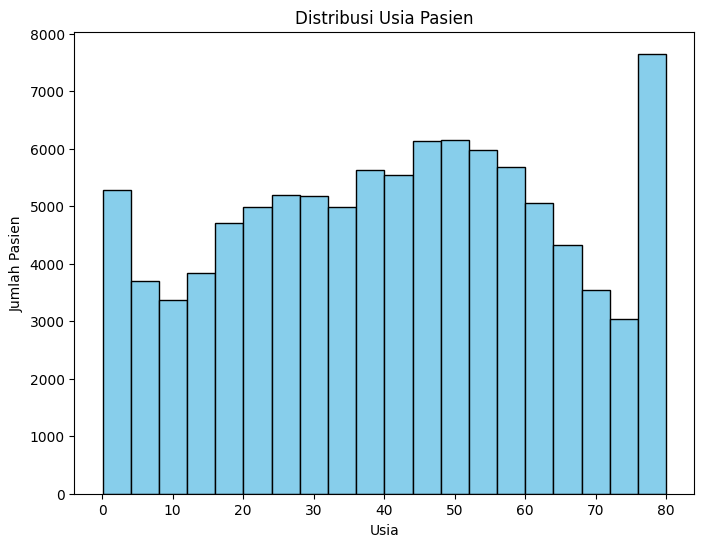

In [ ]:
# Mengambil kolom usia
age_data = data.select("age").toPandas()

# Membuat histogram untuk distribusi usia
plt.figure(figsize=(8, 6))
plt.hist(age_data['age'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribusi Usia Pasien")
plt.xlabel("Usia")
plt.ylabel("Jumlah Pasien")
plt.show()

Histogram ini menggambarkan jumlah pasien berdasarkan kelompok usia.
Sumbu X merepresentasikan kelompok usia pasien (dibagi dalam interval tertentu, misalnya 0-10 tahun, 10-20 tahun, dst.).
Sumbu Y menunjukkan jumlah pasien dalam setiap kelompok usia.

1. Kelompok usia dominan:
*   Usia 50-60 tahun memiliki jumlah pasien tertinggi, dengan sekitar 7.000 pasien.
*   Kelompok usia 80 tahun ke atas juga memiliki jumlah pasien yang signifikan, mendekati 8.000 pasien.

2. Kelompok usia rendah:
Usia 10-20 tahun memiliki jumlah pasien yang relatif rendah dibandingkan kelompok usia lainnya.

3. Pola distribusi:
Secara umum, distribusi usia pasien terlihat merata di kelompok usia tengah (30-60 tahun), dengan sedikit penurunan di usia muda (0-20 tahun) dan usia lansia (70-80 tahun).

4. Insight tambahan:
*   Kelompok usia 50-60 tahun sebagai puncak distribusi dapat menunjukkan bahwa pasien dalam kelompok usia ini lebih sering membutuhkan perawatan atau memiliki kondisi medis tertentu.
*   Lonjakan pasien pada usia 80 tahun ke atas mungkin disebabkan oleh kebutuhan perawatan medis yang lebih tinggi di usia lanjut.



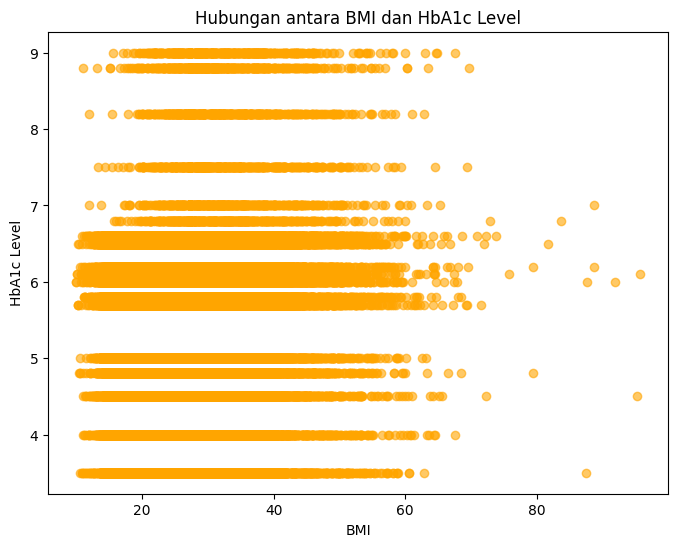

In [ ]:
# Mengambil kolom BMI dan HbA1c
bmi_hba1c_data = data.select("bmi", "HbA1c-level").toPandas()

# Membuat scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(bmi_hba1c_data['bmi'], bmi_hba1c_data['HbA1c-level'], alpha=0.6, color='orange')
plt.title("Hubungan antara BMI dan HbA1c Level")
plt.xlabel("BMI")
plt.ylabel("HbA1c Level")
plt.show()

Scatter plot ini menunjukkan hubungan antara BMI (Body Mass Index) dan HbA1c Level

1. BMI (sumbu X):
Sebagian besar nilai BMI berada dalam rentang 20 hingga 60.
Ada beberapa individu dengan BMI lebih tinggi (hingga sekitar 80).

2. HbA1c Level (sumbu Y):
Sebagian besar level HbA1c berada pada kisaran 4 hingga 7.
Ada titik-titik dengan level HbA1c lebih tinggi, hingga mencapai 9.

3. Distribusi Titik:
Tidak terlihat hubungan yang jelas (linear) antara BMI dan level HbA1c.
Sebagian besar individu dengan HbA1c level yang lebih tinggi (≥7) memiliki BMI bervariasi, tanpa pola yang konsisten.

Plot ini menunjukkan bahwa BMI tidak selalu berbanding lurus dengan HbA1c Level, meskipun ada kecenderungan individu dengan HbA1c tinggi memiliki BMI yang lebih besar. Hubungan lebih lanjut mungkin memerlukan analisis statistik seperti korelasi atau regresi.

#Persiapan data

In [ ]:
# Membuat kolom fitur
feature_cols = ["gender-index", "age", "hypertension", "heart-disease", "smoking-index", "bmi", "HbA1c-level", "blood-glucose-level"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(data)

In [ ]:
# Memilih kolom yang relevan
df = df.select("features", "diabetes")
df.show()

+--------------------+--------+
|            features|diabetes|
+--------------------+--------+
|[0.0,80.0,0.0,1.0...|       0|
|(8,[1,5,6,7],[54....|       0|
|[1.0,28.0,0.0,0.0...|       0|
|[0.0,36.0,0.0,0.0...|       0|
|[1.0,76.0,1.0,1.0...|       0|
|[0.0,20.0,0.0,0.0...|       0|
|[0.0,44.0,0.0,0.0...|       1|
|(8,[1,5,6,7],[79....|       0|
|[1.0,42.0,0.0,0.0...|       0|
|[0.0,32.0,0.0,0.0...|       0|
|[0.0,53.0,0.0,0.0...|       0|
|[0.0,54.0,0.0,0.0...|       0|
|[0.0,78.0,0.0,0.0...|       0|
|[0.0,67.0,0.0,0.0...|       0|
|(8,[1,5,6,7],[76....|       0|
|[1.0,78.0,0.0,0.0...|       0|
|[1.0,15.0,0.0,0.0...|       0|
|[0.0,42.0,0.0,0.0...|       0|
|(8,[1,5,6,7],[42....|       0|
|[1.0,37.0,0.0,0.0...|       0|
+--------------------+--------+
only showing top 20 rows



In [ ]:
# Membagi data menjadi train dan test
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Model Random Forest
rf = RandomForestClassifier(labelCol="diabetes", featuresCol="features")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)

# Model Gradient Boosted Tree
gbt = GBTClassifier(labelCol="diabetes", featuresCol="features", maxIter=10)
gbt_model = gbt.fit(train_data)
gbt_predictions = gbt_model.transform(test_data)

# Model Logistic Regression
lr = LogisticRegression(labelCol="diabetes", featuresCol="features")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)

# Model Naive Bayes
nb = NaiveBayes(labelCol="diabetes", featuresCol="features")
nb_model = nb.fit(train_data)
nb_predictions = nb_model.transform(test_data)

In [ ]:
# prompt: tampilkan AUC, Akurasi, Precision, Recall, dan F1-Score

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluasi dengan AUC, Akurasi, Precision, Recall, dan F1-Score
evaluator = BinaryClassificationEvaluator(labelCol="diabetes", metricName="areaUnderROC")
evaluator_multi = MulticlassClassificationEvaluator(labelCol="diabetes", metricName="accuracy")
evaluator_precision = MulticlassClassificationEvaluator(labelCol="diabetes", metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(labelCol="diabetes", metricName="weightedRecall")
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="diabetes", metricName="f1")


def evaluate_model(predictions, model_name):
    auc = evaluator.evaluate(predictions)
    accuracy = evaluator_multi.evaluate(predictions)
    precision = evaluator_precision.evaluate(predictions)
    recall = evaluator_recall.evaluate(predictions)
    f1 = evaluator_f1.evaluate(predictions)
    print(f"{model_name} - AUC: {auc}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-Score: {f1}")

evaluate_model(rf_predictions, "Random Forest")
evaluate_model(gbt_predictions, "Gradient Boosted Tree")
evaluate_model(lr_predictions, "Logistic Regression")
evaluate_model(nb_predictions, "Naive Bayes")

Random Forest - AUC: 0.9442641668492207, Accuracy: 0.9725359470620429, Precision: 0.9733343963811428, Recall: 0.9725359470620428, F1-Score: 0.9700079279412303
Gradient Boosted Tree - AUC: 0.972954122853685, Accuracy: 0.9725359470620429, Precision: 0.9733343963811428, Recall: 0.9725359470620428, F1-Score: 0.9700079279412303
Logistic Regression - AUC: 0.9617989108040716, Accuracy: 0.961739390019404, Precision: 0.9594658996859231, Recall: 0.961739390019404, F1-Score: 0.9591989009468282
Naive Bayes - AUC: 0.0882257991957189, Accuracy: 0.9025324643017065, Precision: 0.8901339755492327, Recall: 0.9025324643017065, F1-Score: 0.895554958093114


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="diabetes", metricName="areaUnderROC")

# Parameter grid untuk Random Forest
paramGrid_rf = ParamGridBuilder() \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .addGrid(rf.maxBins, [32, 64]) \
    .build()

# CrossValidator untuk Random Forest
crossval_rf = CrossValidator(estimator=rf,
                             estimatorParamMaps=paramGrid_rf,
                             evaluator=evaluator,
                             numFolds=3)

# Melatih model dengan CrossValidator
cv_rf_model = crossval_rf.fit(train_data)

# Prediksi dengan model terbaik
rf_best_model = cv_rf_model.bestModel
rf_predictions_tuned = rf_best_model.transform(test_data)

# Evaluasi performa model terbaik
print("Random Forest (Hyperparameter Tuning):")
evaluate_model(rf_predictions_tuned, "Random Forest")

Random Forest (Hyperparameter Tuning):
Random Forest - AUC: 0.9767299933758943, Accuracy: 0.9721876710284094, Precision: 0.9724231644818887, Recall: 0.9721876710284094, F1-Score: 0.9698333158659133


In [ ]:
# Parameter grid untuk Gradient Boosted Tree
paramGrid_gbt = ParamGridBuilder() \
    .addGrid(gbt.maxDepth, [5, 10, 15]) \
    .addGrid(gbt.maxBins, [32, 64]) \
    .addGrid(gbt.stepSize, [0.1, 0.2, 0.3]) \
    .build()

# CrossValidator untuk Gradient Boosted Tree
crossval_gbt = CrossValidator(estimator=gbt,
                              estimatorParamMaps=paramGrid_gbt,
                              evaluator=evaluator,
                              numFolds=3)

# Melatih model dengan CrossValidator
cv_gbt_model = crossval_gbt.fit(train_data)

# Prediksi dengan model terbaik
gbt_best_model = cv_gbt_model.bestModel
gbt_predictions_tuned = gbt_best_model.transform(test_data)

# Evaluasi performa model terbaik
print("Gradient Boosted Tree (Hyperparameter Tuning):")
evaluate_model(gbt_predictions_tuned, "Gradient Boosted Tree")


Gradient Boosted Tree (Hyperparameter Tuning):
Gradient Boosted Tree - AUC: 0.9783396803477913, Accuracy: 0.9714413652420518, Precision: 0.9709678205811964, Recall: 0.9714413652420519, F1-Score: 0.9693378465622173
